In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [ ]:
#load and prepare data
processed_data = joblib.load('../../data/processed/processed_data.joblib')
X_train = processed_data['X_train']
X_test = processed_data['X_test']
y_train = processed_data['y_train']
y_test = processed_data['y_test']
target_names = processed_data['target_names']
feature_names = processed_data['feature_names']


In [ ]:
# create multiple models
models = {
    'rf': RandomForestClassifier(random_state=42),
    'gb': GradientBoostingClassifier(random_state=42),
    'xgb': XGBClassifier(random_state=42),
    'lgbm': LGBMClassifier(random_state=42)
}

In [ ]:
# define parameter grids for each model
param_grids = {
    'rf': {
        'n_estimators': [200, 300, 400],
        'max_depth': [15, 20, 25],
        'min_samples_split': [2, 5],
        'class_weight': ['balanced']
    },
    'gb': {
        'n_estimators': [200, 300],
        'max_depth': [5, 7],
        'learning_rate': [0.01, 0.1]
    },
    'xgb': {
        'n_estimators': [200, 300],
        'max_depth': [5, 7],
        'learning_rate': [0.01, 0.1]
    },
    'lgbm': {
        'n_estimators': [200, 300],
        'max_depth': [5, 7],
        'learning_rate': [0.01, 0.1]
    }
}

In [ ]:
# train and evaluate each model
best_models = {}
model_scores = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    grid_search = GridSearchCV(
        model,
        param_grids[name],
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    
    # evaluate
    y_pred = best_models[name].predict(X_test)
    score = classification_report(y_test, y_pred, target_names=target_names)
    model_scores[name] = score
    
    print(f"\n{name} Best Parameters:", grid_search.best_params_)
    print(f"\n{name} Performance:\n", score)


Training rf...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

rf Best Parameters: {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}

rf Performance:
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        24
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00   

In [ ]:
#create voting classifier
voting_clf = VotingClassifier(
    estimators=[(name, model) for name, model in best_models.items()],
    voting='soft'
)

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
voting_score = classification_report(y_test, y_pred_voting, target_names=target_names)
print("\nVoting Classifier Performance:\n", voting_score)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 3936, number of used features: 131
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start trai

In [ ]:
#advanced analysis functions
def plot_roc_curves(models, X, y):
    plt.figure(figsize=(10, 8))
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X)
        roc_score = roc_auc_score(y, y_pred_proba, multi_class='ovr')
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_score:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()

def analyze_disease_symptom_relationships(X, y, feature_names, target_names):
    relationships = pd.DataFrame(index=feature_names, columns=target_names)
    for disease_idx, disease in enumerate(target_names):
        disease_mask = (y == disease_idx)
        disease_cases = X[disease_mask]
        symptom_frequencies = disease_cases.mean(axis=0)
        relationships[disease] = symptom_frequencies
    return relationships

In [ ]:
#save Results
results = {
    'models': best_models,
    'voting_classifier': voting_clf,
    'feature_names': feature_names,
    'target_names': target_names,
    'model_scores': model_scores
}

joblib.dump(results, '../../models/ensemble_models.joblib')


['../../models/ensemble_models.joblib']

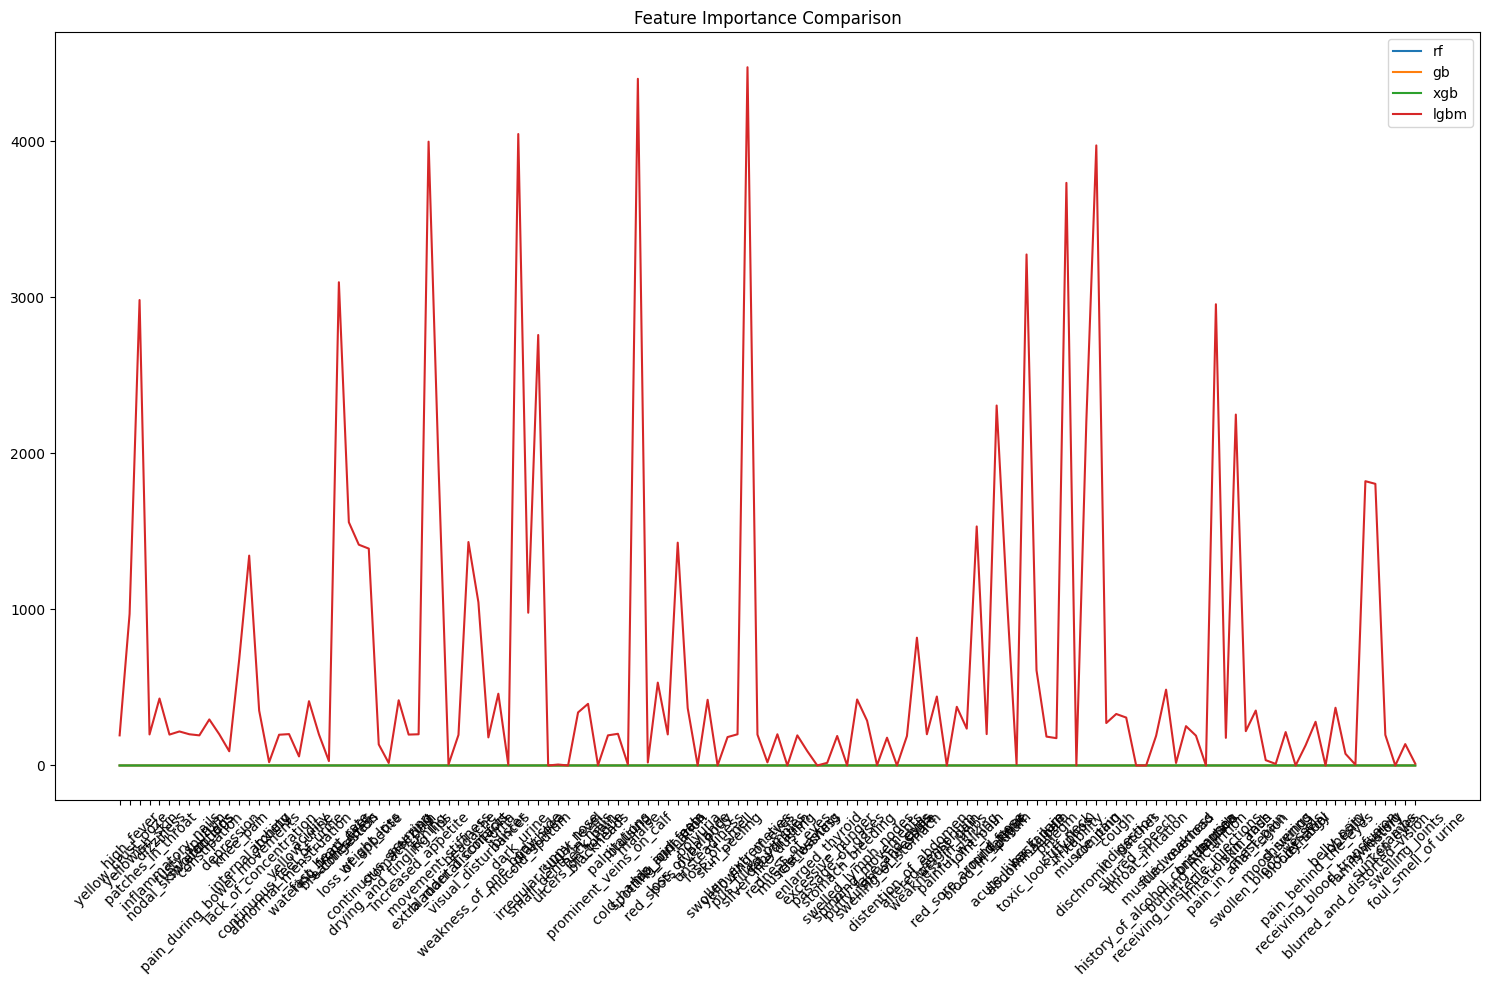

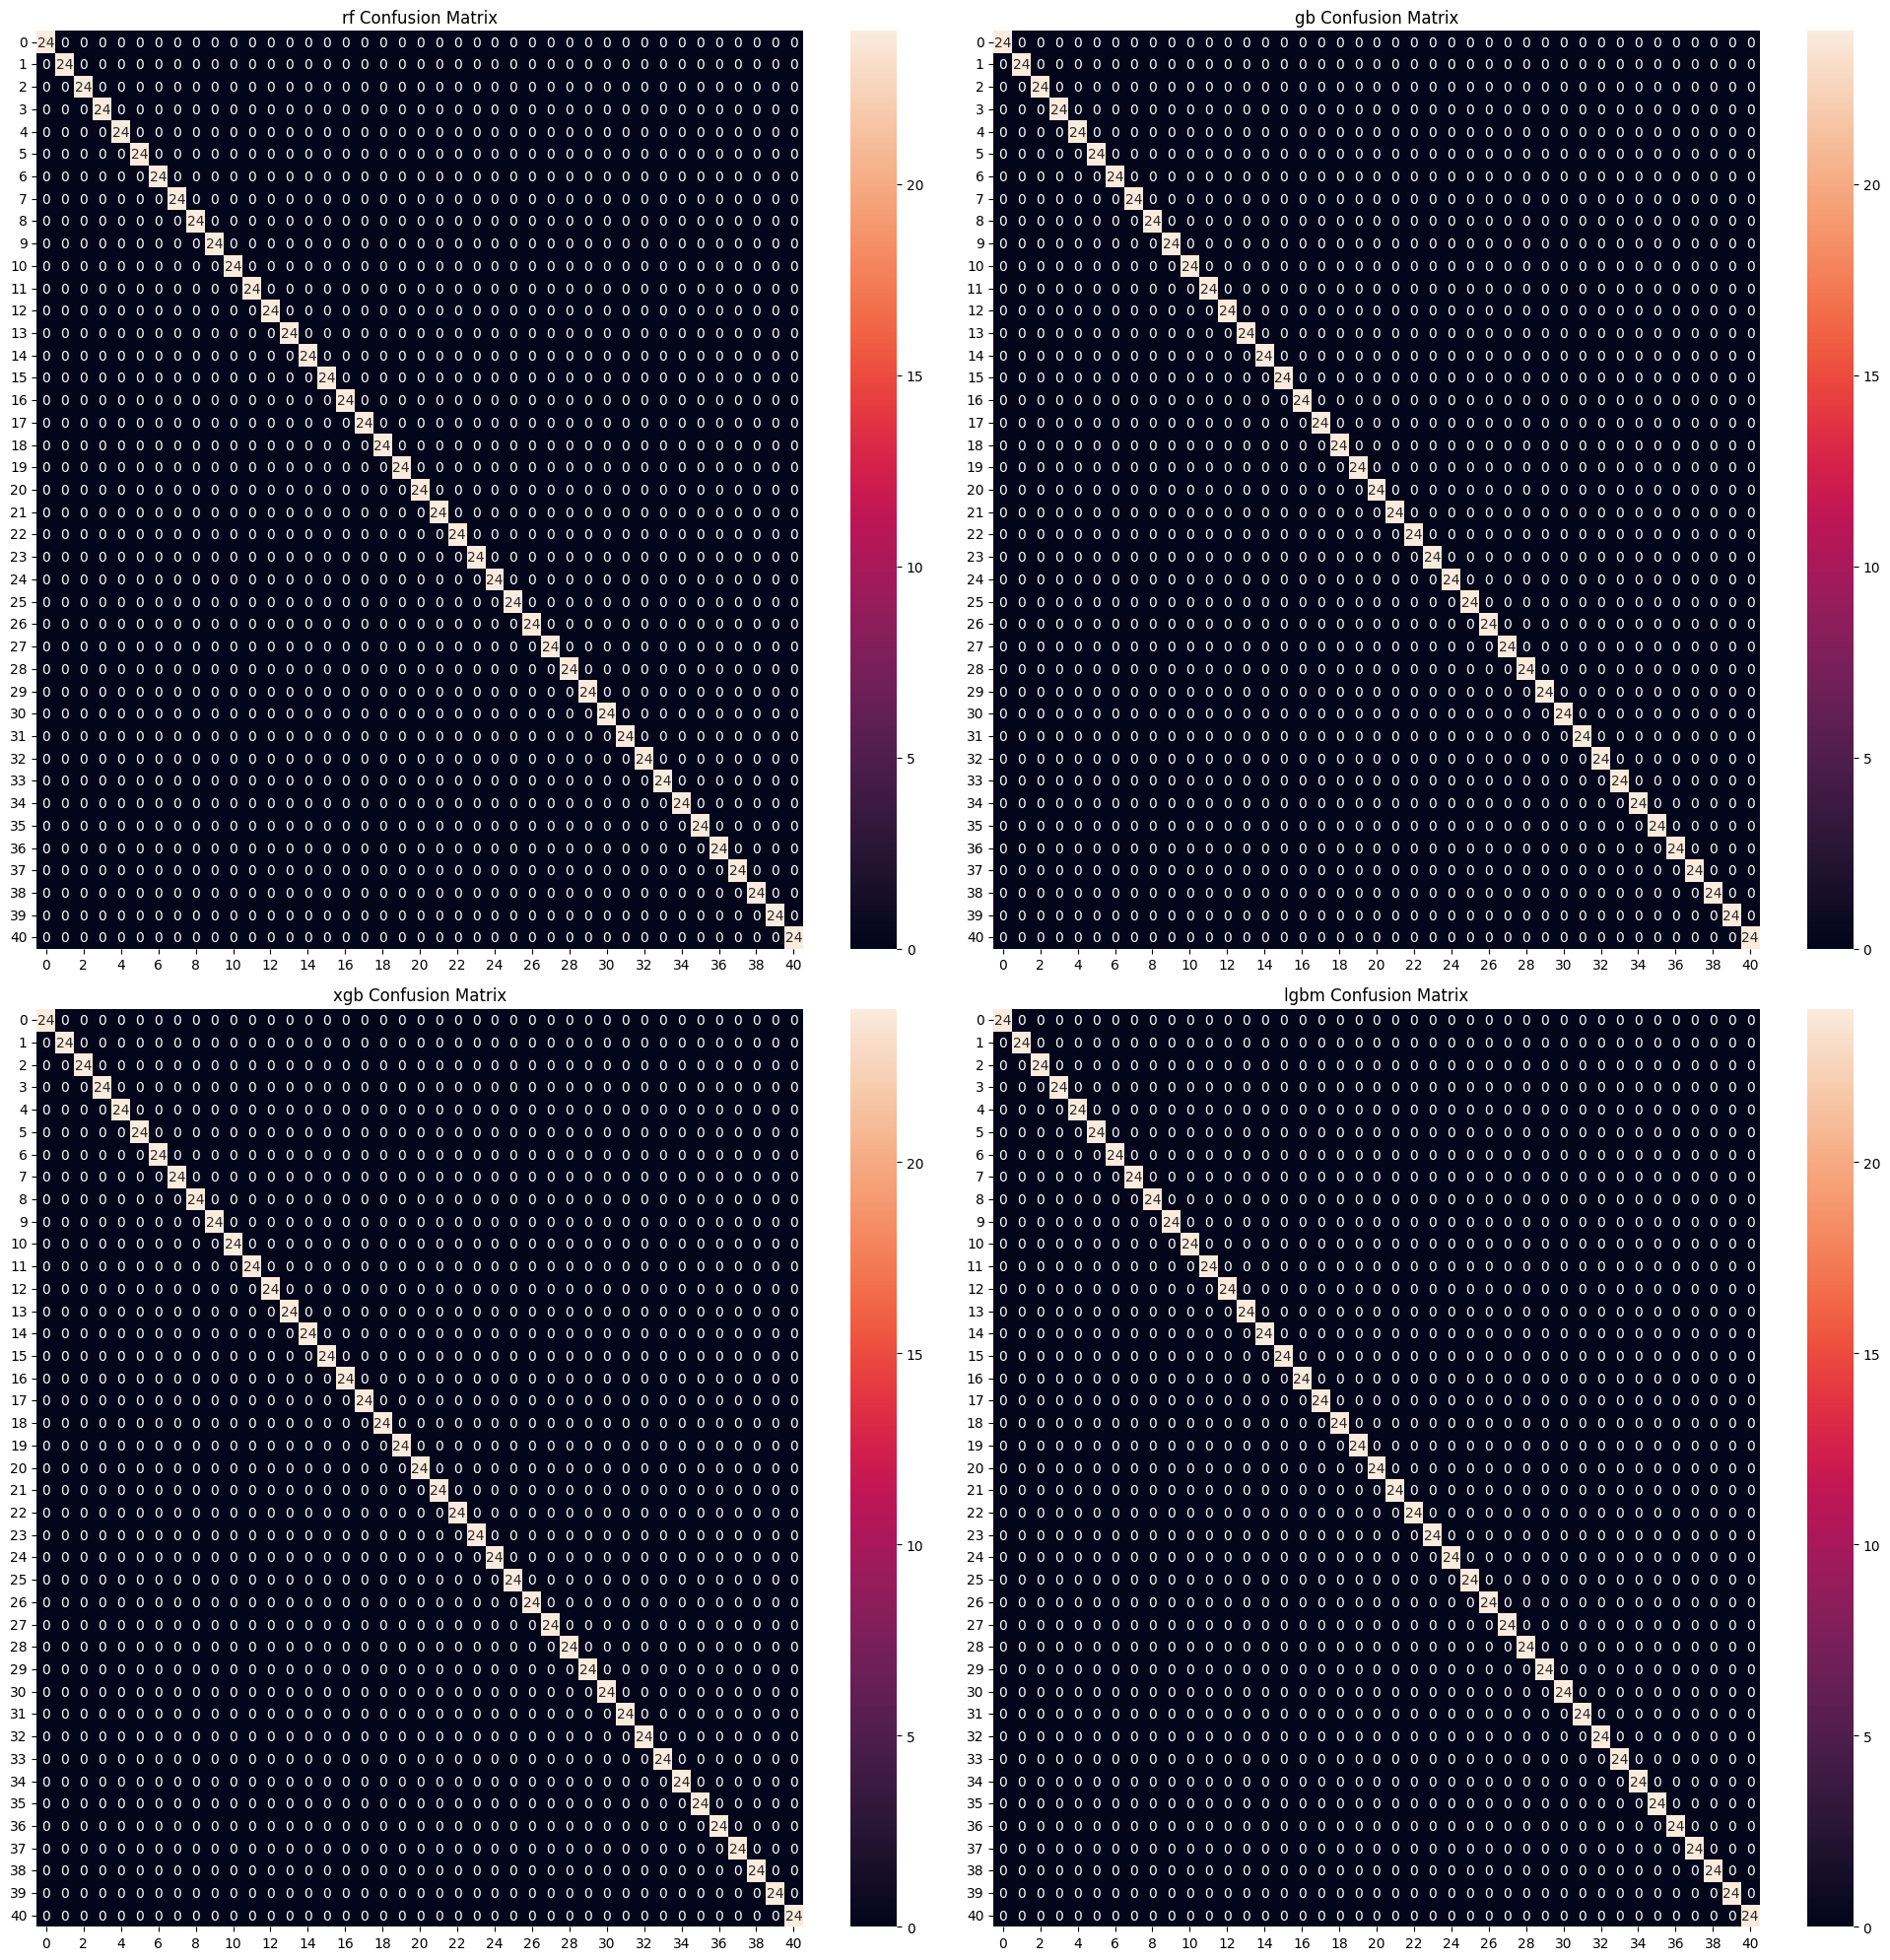

In [ ]:
# generate Visualizations
def create_visualizations():
    # Feature importance comparison
    plt.figure(figsize=(15, 10))
    for name, model in best_models.items():
        if hasattr(model, 'feature_importances_'):
            plt.plot(model.feature_importances_, label=name)
    plt.xticks(range(len(feature_names)), feature_names, rotation=45)
    plt.legend()
    plt.title('Feature Importance Comparison')
    plt.tight_layout()
    plt.savefig('../../src/visualizations/feature_importance_comparison.png')

    #cnfusion matrices
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    for (name, model), ax in zip(best_models.items(), axes.ravel()):
        cm = confusion_matrix(y_test, model.predict(X_test))
        sns.heatmap(cm, annot=True, fmt='d', ax=ax)
        ax.set_title(f'{name} Confusion Matrix')
    plt.tight_layout()
    plt.savefig('../../src/visualizations/confusion_matrices.png')

create_visualizations()


In [ ]:

#save symptom-disease relationships
relationships = analyze_disease_symptom_relationships(X_train, y_train, feature_names, target_names)
relationships.to_csv('../../data/processed/symptom_disease_relationships.csv')

In [ ]:
import requests

: 